# Solución propuesta Evaluación 4

Duoc UC  
Deep Learning DLY0100-002V  
Profesor Jorge Anais  
Junio 2023  

**Nota**: La imiplementación propuesta aquí es para propósitos pedagógicos, y puede ser altamente ineficiente en términos de cómputo.

In [1]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np
import pandas as pd
import re
import string


from numpy.random import seed
seed(1123)

import tensorflow
tensorflow.random.set_seed(123)

## Cargar los datos y explorarlos

Cargamos los datos desde google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = "/content/drive/MyDrive/2023-1/DLY0100/notebooks/ev4_jorge/TweetsClasificacion.csv"

Queremos entender como lucen nuestros datos. Note que colab corre sobre una máquina virtual linux, por lo tanto puede usar las mismas utilidades que cualquier máquina linux. En este caso, utilizo el programa `head` y `tail`, que muestra las primeras y últimas 10 líneas de un fichero, respectivamente.

El comando `wc -l` nos permite contar el número de líneas

No olvide anteponer un signo de exclamación antes de utilizar el comando.

In [4]:
!head /content/drive/MyDrive/2023-1/DLY0100/notebooks/ev4_jorge/TweetsClasificacion.csv

Positivo;I LOVE u guys r the best!!  http://bkite.com/06fuJ
Positivo;im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
Positivo;Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
Positivo;he has that effect on everyone 
Positivo;You can tell him that I just burst out laughing really loud because of that  Thanks for making me come out of my sulk!
Positivo;Thans for your response. Ihad already find this answer 
Positivo;I am so jealous, hope you had a great time in vegas! how did you like the ACM's?! LOVE YOUR SHOW!! 
Positivo;ah, congrats mr fletcher for finally joining twitter 
Positivo;I RESPONDED  Stupid cat is helping me type. Forgive errors 
Positivo;crazy day of school. there for 10 hours straiiight. about to watch the hills. spencerpratt told me too! ha. happy birthday JB! 


In [5]:
!tail /content/drive/MyDrive/2023-1/DLY0100/notebooks/ev4_jorge/TweetsClasificacion.csv

Negativo;Just payed my WAY OVERDUE zta dues. Goodbye $350. That's a good two wks of work.  how depressing. Ruined my day....but at least it's done.
Negativo;and I think it has a mind of its own,like it always ring when I'm taking a leak..jeez that makes whole thing embarrassingly musical 
Negativo; Banana will be playing later. BUT. Shell be playing with Caro.
Negativo;read my tweet below 
Negativo;My life  http://mattf.ca/2009/06/24/yay-me/
Negativo;Tried to get the mutant Fawkes to follow me but he wouldn't  it's so lonely without followers I have never had one :$
Negativo;Sick  Spending my day laying in bed listening to taylorswift13
Negativo;Gmail is down? 
Negativo;rest in peace Farrah! So sad 
Negativo;Sounds like a rival is flagging your ads. Not much you can do about that though


In [6]:
!wc -l /content/drive/MyDrive/2023-1/DLY0100/notebooks/ev4_jorge/TweetsClasificacion.csv

1599997 /content/drive/MyDrive/2023-1/DLY0100/notebooks/ev4_jorge/TweetsClasificacion.csv


Leemos el archivo utilizando pandas. Ahora sabemos que el separador utilizado es punto y coma, y que son dos columnas, donde la primera corresponde al sentimiento y la segunda al texto del *tweet*. Además el archivo tiene 1 millón y medio de líneas.

In [7]:
df = pd.read_csv(data_path, sep=";", header=None, names=["sentimiento", "texto"])

In [8]:
df

,sentimiento,texto
0,Positivo,I LOVE u guys r the best!! http://bkite.com/0...
1,Positivo,im meeting up with one of my besties tonight! ...
2,Positivo,Being sick can be really cheap when it hurts t...
3,Positivo,he has that effect on everyone
4,Positivo,You can tell him that I just burst out laughin...
...,...,...
1599992,Negativo,Tried to get the mutant Fawkes to follow me bu...
1599993,Negativo,Sick Spending my day laying in bed listening ...
1599994,Negativo,Gmail is down?
1599995,Negativo,rest in peace Farrah! So sad


Para simplificar un poco nuestro análisis eliminaremos los simbolos muy rebuscados. Es decir, solo nos quedamos con los caracteres alfanuméricos y unos pocos simbolos (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~). Puede modificarlo si gusta, una opción interesante es solo utilizar carácteres alfanuméricos, dejando de lado los símbolos.

In [9]:
def remove_special_characters(text):

    # Reemplazamos el caracter especial \xa0 que representa un espacio
    text = text.replace(u'\xa0', u' ')

    # Tambien eliminamos los tab y los reemplazamos por un espacio
    text = text.replace(u'\t', u' ')

    # Definir el patrón de la expresión regular
    pattern = r'[^a-zA-Z0-9\s' + re.escape(string.punctuation) + ']'

    # Remover los caracteres especiales
    processed_text = re.sub(pattern, '', text)

    return processed_text

In [10]:
df['texto_limpio'] = df['texto'].apply(remove_special_characters)

In [11]:
df

,sentimiento,texto,texto_limpio
0,Positivo,I LOVE u guys r the best!! http://bkite.com/0...,I LOVE u guys r the best!! http://bkite.com/0...
1,Positivo,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...
2,Positivo,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...
3,Positivo,he has that effect on everyone,he has that effect on everyone
4,Positivo,You can tell him that I just burst out laughin...,You can tell him that I just burst out laughin...
...,...,...,...
1599992,Negativo,Tried to get the mutant Fawkes to follow me bu...,Tried to get the mutant Fawkes to follow me bu...
1599993,Negativo,Sick Spending my day laying in bed listening ...,Sick Spending my day laying in bed listening ...
1599994,Negativo,Gmail is down?,Gmail is down?
1599995,Negativo,rest in peace Farrah! So sad,rest in peace Farrah! So sad


Primero transformaremos los sentimientos guardados en la lista labels en una variable numérica. 0 para negativo y 1 para positivo. Para eso utilizaré un diccionario que contiene la transformación

In [12]:
transf_sentimiento = {
    'Negativo': 0,
    'Positivo': 1,
}

In [13]:
df['sentimiento_numerico'] = df['sentimiento'].map(transf_sentimiento)

In [14]:
df

,sentimiento,texto,texto_limpio,sentimiento_numerico
0,Positivo,I LOVE u guys r the best!! http://bkite.com/0...,I LOVE u guys r the best!! http://bkite.com/0...,1
1,Positivo,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...,1
2,Positivo,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...,1
3,Positivo,he has that effect on everyone,he has that effect on everyone,1
4,Positivo,You can tell him that I just burst out laughin...,You can tell him that I just burst out laughin...,1
...,...,...,...,...
1599992,Negativo,Tried to get the mutant Fawkes to follow me bu...,Tried to get the mutant Fawkes to follow me bu...,0
1599993,Negativo,Sick Spending my day laying in bed listening ...,Sick Spending my day laying in bed listening ...,0
1599994,Negativo,Gmail is down?,Gmail is down?,0
1599995,Negativo,rest in peace Farrah! So sad,rest in peace Farrah! So sad,0


El conjunto de datos tiene más de un millón y medio de *tweets*. Sin pérdida de generalidad, tomaremos una muestra más pequeña, de 10000 *tweets*, que nos permita entrenar nuestra red recurrente en un tiempo razonable.

In [15]:
muestra_df = df.sample(n=10000)

Nos cercioramos que tenemos una cantidad similar de ejemplos negativos y positivos.

In [16]:
muestra_df.groupby("sentimiento").count()

,texto,texto_limpio,sentimiento_numerico
sentimiento,,,
Negativo,5087,5087,5087
Positivo,4913,4913,4913


Ahora transformaremos los textos en secuencias numéricas. Para ello necesitamos hacer un "mapeo" de carácteres a números. Lo que haremos será primero ver que carácteres tenemos en nuestro conjunto de datos, y luego darle a cada uno de ellos un número único. Para ello utilizaremos el siguiente código que nos retorna un `set` con los caracteres que no se repiten y que estan presentes en nuestra muestra (ref: https://stackoverflow.com/questions/44226628/get-unique-list-of-chars-used-in-a-given-column). Note que por definición, un `set` en python es un conjunto de elementos únicos ¡justo lo que necesitamos!.

In [17]:
input_characters = set(muestra_df['texto_limpio'].apply(list).sum())

In [18]:
input_characters = sorted(list(input_characters))
input_characters

[' ',
 '!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~']

A cada caracter le asignamos un numero según el orden en que están en nuestra lista. También creamos la transformación contraria, por si nos es útil más adelante.

In [19]:
transf_char_to_num = {char: i for i, char in enumerate(input_characters)}
transf_num_to_char = dict((i, c) for i, c in enumerate(input_characters))

Ahora aplicamos la trasnformación anterior a nuestros datos

In [20]:
def transform_sentence_to_numbers(sentence):
    return [transf_char_to_num[char] for char in sentence]

In [21]:
 muestra_df['texto_numerico'] = muestra_df['texto_limpio'].map(transform_sentence_to_numbers)

In [22]:
muestra_df

,sentimiento,texto,texto_limpio,sentimiento_numerico,texto_numerico
6459,Positivo,"Gimme that $1m, we'll take a tour to the UK, a...","Gimme that $1m, we'll take a tour to the UK, a...",1,"[34, 68, 72, 72, 64, 0, 79, 67, 60, 79, 0, 3, ..."
429715,Positivo,is watching *You've Got Mail* on HBO. http://...,is watching *You've Got Mail* on HBO. http://...,1,"[68, 78, 0, 82, 60, 79, 62, 67, 68, 73, 66, 0,..."
314062,Positivo,bored! anyone wanna do something? txt me!,bored! anyone wanna do something? txt me!,1,"[61, 74, 77, 64, 63, 1, 0, 60, 73, 84, 74, 73,..."
803930,Negativo,ARGH! GEESE ATTACK!!!,ARGH! GEESE ATTACK!!!,0,"[28, 45, 34, 35, 1, 0, 34, 32, 32, 46, 32, 0, ..."
21234,Positivo,is LOVING this weather!!,is LOVING this weather!!,1,"[68, 78, 0, 39, 42, 49, 36, 41, 34, 0, 79, 67,..."
...,...,...,...,...,...
25927,Positivo,Happy Sunday to you as well.,Happy Sunday to you as well.,1,"[35, 60, 75, 75, 84, 0, 46, 80, 73, 63, 60, 84..."
113942,Positivo,"Is finally back from the dinner party, had fun...","Is finally back from the dinner party, had fun...",1,"[36, 78, 0, 65, 68, 73, 60, 71, 71, 84, 0, 61,..."
252513,Positivo,xD gives me many lols,xD gives me many lols,1,"[83, 31, 0, 66, 68, 81, 64, 78, 0, 72, 64, 0, ..."
712487,Positivo,Just got it!,Just got it!,1,"[37, 80, 78, 79, 0, 66, 74, 79, 0, 68, 79, 1, 0]"


## Vectorización de los datos

Una vez que hemos preprocesado los datos, procederemos a darle forma a los datos de modo que puedan alimentar nuestra red neuronal. Para ello utilizaremos arreglos Numpy.

Lo primero que tenemos que lograr es crear un tensor de entrada con dimensiones fijas. Recuerde de que una red recursiva puede trabajar con entradas de largo variable, sin embargo, realizaremos una implementación más sencilla para términos demostrativos. La idea es buscar el tweet más largo de los que tenemos, y usar ese largo para todo el resto. Los espacios faltantes los rellenamos con ceros (equivalente a espacios).

También utilizamos la técnica de one-hot encoding sobre los caracteres, es decir, utilizamos una representación del tipo:
```
       |  0  |           | ' ' |
       | ... |           | ... |
       |  0  |           | 'v' |
       |  0  |           | 'w' |
'x' -> |  1  |   donde   | 'x' |
       |  0  |           | 'y' |
       |  0  |           | 'z' |
       | ... |           | ... |
       |  0  |           | '~' |
```

In [23]:
# Transformamos la columna 'texto_numerico' en una lista de listas.
input_texts = list(muestra_df['texto_numerico'].values)

# Transformamos la columna 'sentimiento_numerico' en una lista de ints.
sentimiento_target = list(muestra_df['sentimiento_numerico'].values)

In [24]:
# Buscamos el tweet mas largo
max_seq_length = max([len(txt) for txt in input_texts])
print(max_seq_length)

169


In [25]:
# Contamos cuantos caracteres distintos tenemos
num_caracteres_unicos = len(input_characters)
print(num_caracteres_unicos)

90


In [26]:
# Ahora creamos el numpy array para el tensor de entrada (inicializado todo en cero)
# Shape=(# ejemplos, # caracteres tweet mas largo, # de caracteres distintos)
input_shape = (
    len(input_texts),
    max_seq_length,
    num_caracteres_unicos,
)

X = np.zeros(input_shape, dtype='float32')

In [27]:
input_shape

(10000, 169, 90)

In [28]:
# Rellenamos el Numpy array input_data con los datos preprocesados
for i, input_text in enumerate(input_texts):
    for t, token in enumerate(reversed(input_text)):
      X[i, -(t+1), token] = 1.

Notar el truco que podría pasar desapercibido: el texto se coloca "alineado a la izquierda". Por ejemplo, seria algo así:

```
[0 0 0 0 0 0 0 0 0 t e x to]
```


La motivación es que dado que la red recurrente pasa información de izquierda a derecha, es probable que la información que está más a la izquierda se diluya a medida que se va iterando. Hay formas más elegantes de solucionar este problema (máscaras), pero la idea aquí es mantener el ejemplo lo más sencillo posible.

Ahora creamos el tensor que es nuestra etiqueta (0 o 1 dependiendo si es un sentimiento positivo o negativo)

In [29]:
output_shape = (len(input_texts), 2)
y = np.zeros(output_shape, dtype='float32')

In [30]:
for i, sentimiento in enumerate(sentimiento_target):
    y[i, sentimiento] = 1

## Dividimos los datos en Test y train

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,
    random_state=42
)

## Redes recurrentes

A continuación, veamos unos ejemplos muy sencillos de redes recurrentes de una sola capa.

### Red recurrente Simple de una capa

Ahora creamos una red recurrente para entrenarla con el conjunto de datos que creamos anteriormente.

In [32]:
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from keras.models import Sequential
from keras.layers import Dense, Activation

import matplotlib.pyplot as plt

In [33]:
HIDDEN_SIZE = 128
BATCH_SIZE = 64

In [34]:
model = Sequential()
model.add(
    SimpleRNN(
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(max_seq_length, num_caracteres_unicos),
        unroll=True
        )
    )
model.add(Dense(2))  # Dos salidas posibles: 0 ó 1
model.add(Activation("softmax"))



In [35]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               28032     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 28,290
Trainable params: 28,290
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=20
)

Epoch 1/20
105/105 [==============================] - 24s 107ms/step - loss: 0.6955 - accuracy: 0.5410 - val_loss: 0.7376 - val_accuracy: 0.5133
Epoch 2/20
105/105 [==============================] - 8s 79ms/step - loss: 0.6773 - accuracy: 0.5775 - val_loss: 0.6826 - val_accuracy: 0.5497
Epoch 3/20
105/105 [==============================] - 9s 87ms/step - loss: 0.6737 - accuracy: 0.5839 - val_loss: 0.6835 - val_accuracy: 0.5594
Epoch 4/20
105/105 [==============================] - 8s 76ms/step - loss: 0.6639 - accuracy: 0.5979 - val_loss: 0.6929 - val_accuracy: 0.5621
Epoch 5/20
105/105 [==============================] - 9s 84ms/step - loss: 0.6640 - accuracy: 0.5979 - val_loss: 0.7183 - val_accuracy: 0.5303
Epoch 6/20
105/105 [==============================] - 8s 81ms/step - loss: 0.6654 - accuracy: 0.5970 - val_loss: 0.6953 - val_accuracy: 0.5555
Epoch 7/20
105/105 [==============================] - 8s 81ms/step - loss: 0.6554 - accuracy: 0.6097 - val_loss: 0.6939 - val_accuracy: 0.54

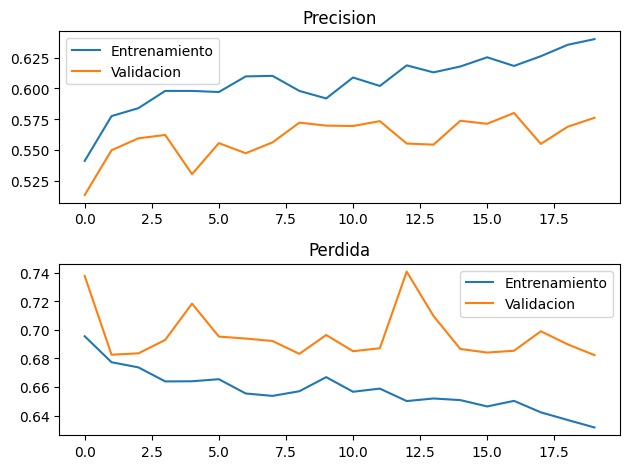

In [38]:
plt.subplot(211)
plt.title('Precision')
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validacion')
plt.legend(loc='upper left')

plt.subplot(212)
plt.title('Perdida')
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validacion')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Ahora veamos un ejemplo concreto para ver que tal funciona nuestra red.

In [39]:
# Ejemplo a probar
ejemplo = "rest in peace Farrah! So sad"  # Sabemos que es negativo

# Transformamos utilizando nuestra representacion numerica
ejemplo_en_numeros = transform_sentence_to_numbers(ejemplo)

# Creamos el tensor. La primera dimension es 1 porque es "un" solo ejemplo
texto_tensor_ejemplo = np.zeros(shape=(1, max_seq_length, num_caracteres_unicos))

# Rellenamos el tensor con el texto de ejemplo ya transformado
for t, token in enumerate(reversed(ejemplo_en_numeros)):
      texto_tensor_ejemplo[0, -(t+1), token] = 1.



In [40]:
# Ahora lo probamos en la red
pred = model.predict(texto_tensor_ejemplo)

1/1 [==============================] - 2s 2s/step


In [41]:
print(pred)

[[0.5387852  0.46121478]]


Observamos que a pesar de que la predicción es correcta (53% a que es un sentimiento negativo), realmente esta predicción no es muy robusta, ya que el valor es muy cercano al 50% (equivalente a lanzar una moneda al aire).

### Red Recurrente LSTM

In [42]:
model = Sequential()
model.add(
    LSTM(
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(max_seq_length, num_caracteres_unicos),
        unroll=True
        )
    )
model.add(Dense(2))  # Dos salidas posibles: 0 ó 1
model.add(Activation("softmax"))

In [43]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               112128    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 112,386
Trainable params: 112,386
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=20
)

Epoch 1/20
105/105 [==============================] - 84s 445ms/step - loss: 0.6850 - accuracy: 0.5504 - val_loss: 0.6800 - val_accuracy: 0.5676
Epoch 2/20
105/105 [==============================] - 46s 441ms/step - loss: 0.6723 - accuracy: 0.5928 - val_loss: 0.6730 - val_accuracy: 0.5900
Epoch 3/20
105/105 [==============================] - 52s 497ms/step - loss: 0.6647 - accuracy: 0.6028 - val_loss: 0.6685 - val_accuracy: 0.5948
Epoch 4/20
105/105 [==============================] - 35s 333ms/step - loss: 0.6553 - accuracy: 0.6152 - val_loss: 0.6636 - val_accuracy: 0.6058
Epoch 5/20
105/105 [==============================] - 39s 376ms/step - loss: 0.6521 - accuracy: 0.6225 - val_loss: 0.6632 - val_accuracy: 0.6061
Epoch 6/20
105/105 [==============================] - 39s 363ms/step - loss: 0.6483 - accuracy: 0.6178 - val_loss: 0.6586 - val_accuracy: 0.6161
Epoch 7/20
105/105 [==============================] - 37s 355ms/step - loss: 0.6452 - accuracy: 0.6296 - val_loss: 0.6598 - val_ac

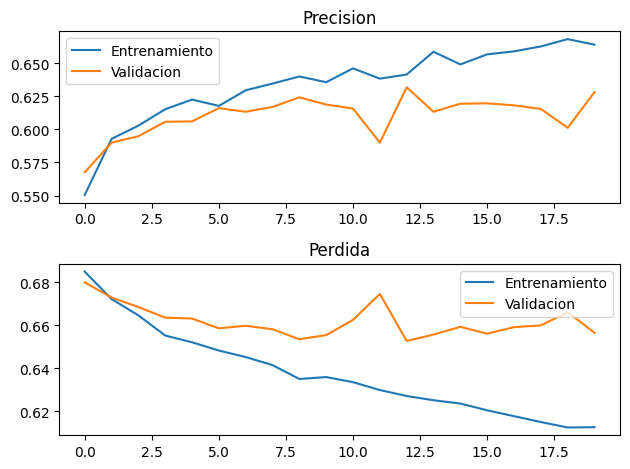

In [46]:
plt.subplot(211)
plt.title('Precision')
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validacion')
plt.legend(loc='upper left')

plt.subplot(212)
plt.title('Perdida')
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validacion')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Red Recurrente LSTM bidireccional

In [47]:
model = Sequential()
model.add(
    Bidirectional(
        LSTM(
            HIDDEN_SIZE,
            return_sequences=False,
        ),
        input_shape=(max_seq_length, num_caracteres_unicos),
    )
)

model.add(Dense(2))  # Dos salidas posibles: 0 ó 1
model.add(Activation("softmax"))

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              224256    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
Total params: 224,770
Trainable params: 224,770
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)

In [51]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=20
)

Epoch 1/20
105/105 [==============================] - 86s 819ms/step - loss: 0.6545 - accuracy: 0.6187 - val_loss: 0.6677 - val_accuracy: 0.5976
Epoch 2/20
105/105 [==============================] - 79s 756ms/step - loss: 0.6579 - accuracy: 0.6143 - val_loss: 0.6646 - val_accuracy: 0.6045
Epoch 3/20
105/105 [==============================] - 84s 803ms/step - loss: 0.6516 - accuracy: 0.6290 - val_loss: 0.6565 - val_accuracy: 0.6197
Epoch 4/20
105/105 [==============================] - 89s 841ms/step - loss: 0.6447 - accuracy: 0.6282 - val_loss: 0.6679 - val_accuracy: 0.6021
Epoch 5/20
105/105 [==============================] - 86s 826ms/step - loss: 0.6470 - accuracy: 0.6363 - val_loss: 0.6625 - val_accuracy: 0.6145
Epoch 6/20
105/105 [==============================] - 94s 899ms/step - loss: 0.6421 - accuracy: 0.6291 - val_loss: 0.6564 - val_accuracy: 0.6236
Epoch 7/20
105/105 [==============================] - 85s 817ms/step - loss: 0.6373 - accuracy: 0.6387 - val_loss: 0.6591 - val_ac

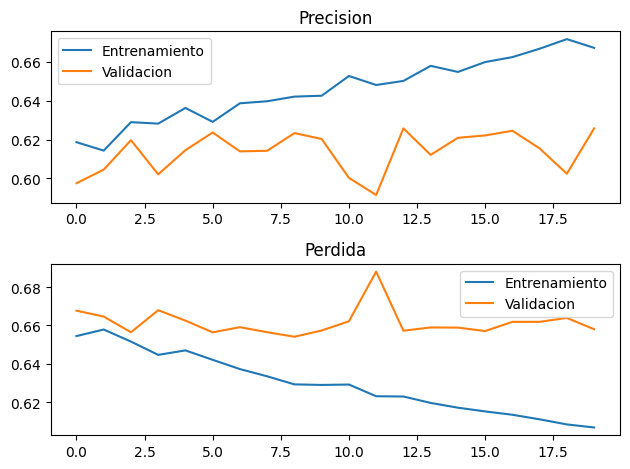

In [52]:
plt.subplot(211)
plt.title('Precision')
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validacion')
plt.legend(loc='upper left')

plt.subplot(212)
plt.title('Perdida')
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validacion')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Por último les dejo unas preguntas para que refleccionar.

¿Cuál es la red con mejor rendimiento? ¿qué podemos hacer para incrementar aún más el procentaje de acierto de la red? ¿cómo podemos aumentar la capacidad de la red?¿Creees que utilizar caractéres es una buena idea? ¿Qué alternativas distinas propondrías?